In [3]:
import os
import numpy as np
import ast

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [4]:
from SLModel import CNN_RNN_Model

In [5]:
DATASET_FOLDER = 'Dataset'
MODEL_FOLDER = 'Models'

# DATA PREP

In [6]:
X = []
Y = []

for file in os.listdir(DATASET_FOLDER):
    name, ext = os.path.splitext(file)
    if ext == '.txt':
        with open(os.path.join(DATASET_FOLDER, file), 'r') as f:
            read_list = ast.literal_eval(f.read())
            for i in read_list:
                X.append(i)
                Y.append(name)

X = np.array(X, dtype=np.float32)

In [7]:
uniques_y = list(set(Y))

uniques_y

['what',
 'jump',
 'look',
 'dark',
 'sleep',
 'sad',
 'drink',
 'open',
 'hot',
 'face2',
 'low',
 'hello',
 'talk',
 'push',
 'happy',
 'again',
 'strong',
 'deaf',
 'slow',
 'sorry',
 'bright',
 'say',
 'big',
 'ice creame',
 'me',
 'buy',
 'loud',
 'watch',
 'near',
 'close',
 'here',
 'outside',
 'I love you',
 'eat',
 'come',
 'thick',
 'fast',
 'help',
 'cold',
 'sit',
 'thank you',
 'there',
 'drive',
 'yes',
 'write',
 'stop',
 'please2',
 'soft',
 'no',
 'go']

In [8]:
for i in range(len(Y)):
    new_y = [0] * len(uniques_y)
    idx = uniques_y.index(Y[i])
    new_y[idx] = 1
    Y[i] = new_y

Y = np.array(Y, dtype=np.int32)

In [9]:
X.shape, Y.shape

((1500, 20, 75, 3), (1500, 50))

### Build relative landmark coordinates

In [13]:
x_min = X.min(axis=2, keepdims=True)
x_max = X.max(axis=2, keepdims=True)
denom = x_max - x_min
denom[denom == 0] = 1

X = (X - x_min) / denom

In [14]:
reference_landmark_idx = 42
reference_coords = X[:, :, reference_landmark_idx, :]

X = X[:, :, :, :] - reference_coords[:, :, np.newaxis, :]

In [16]:
class SignLanguageDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        Args:
            sequences (list of tensors): Each tensor has shape (sequence_length, num_landmarks, channels).
            labels (list of int): Movement class labels corresponding to each sequence.
        """
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Get the sequence and its label
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        # Convert to torch tensors if they aren't already
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        
        return sequence, label


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

sign_language_dataset_train = SignLanguageDataset(X_train, Y_train)
sign_language_dataset_test = SignLanguageDataset(X_test, Y_test)

In [18]:
train_loader = DataLoader(dataset=sign_language_dataset_train, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=sign_language_dataset_test, batch_size=16, shuffle=True, num_workers=0)

# DATA VISUALIZATION

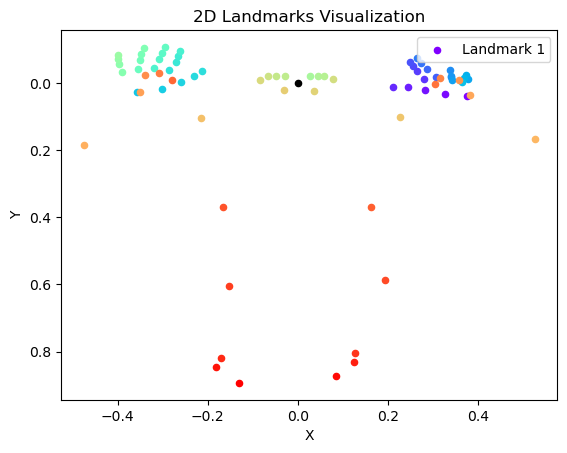

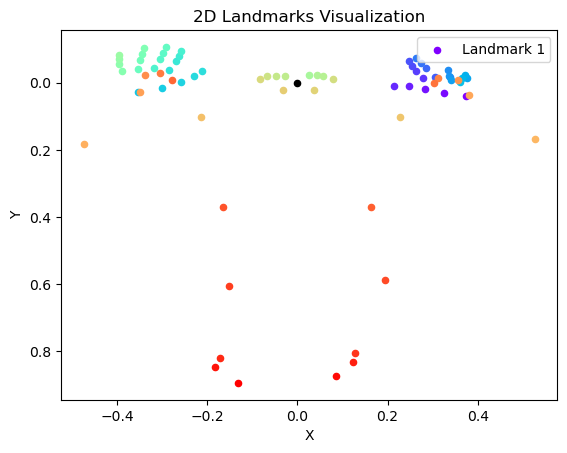

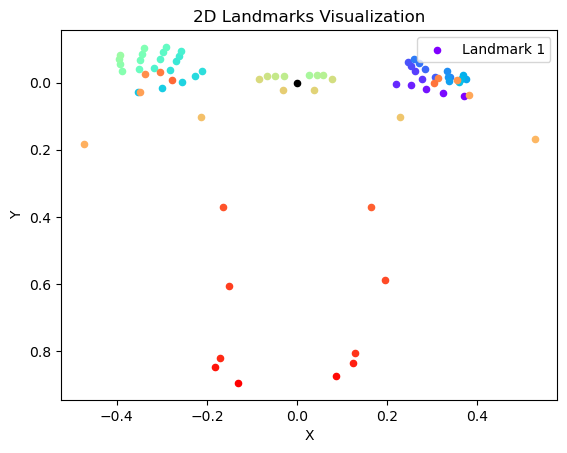

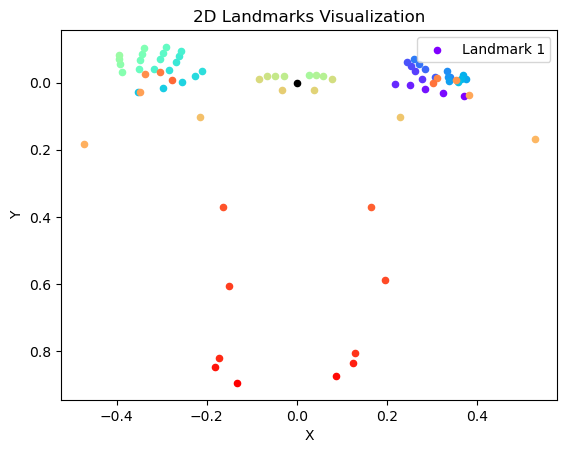

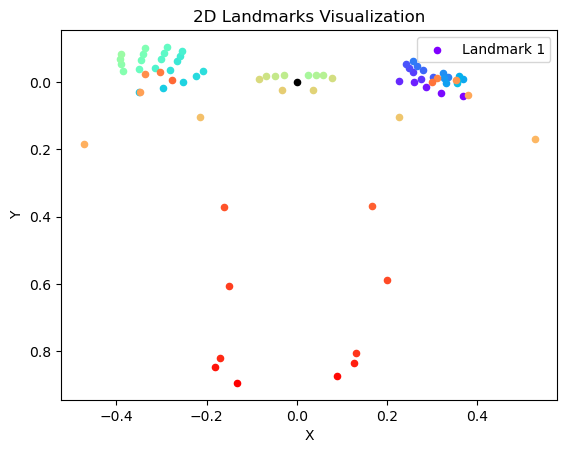

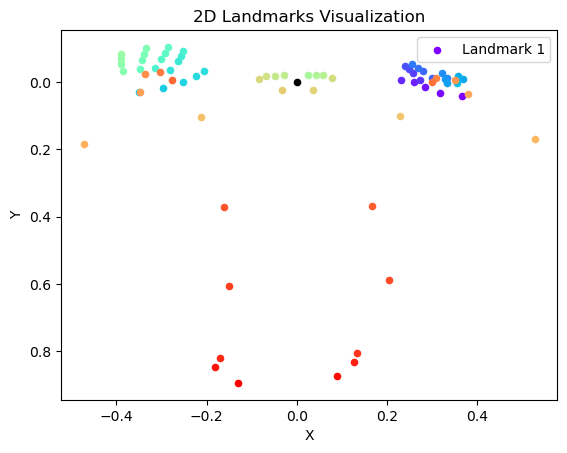

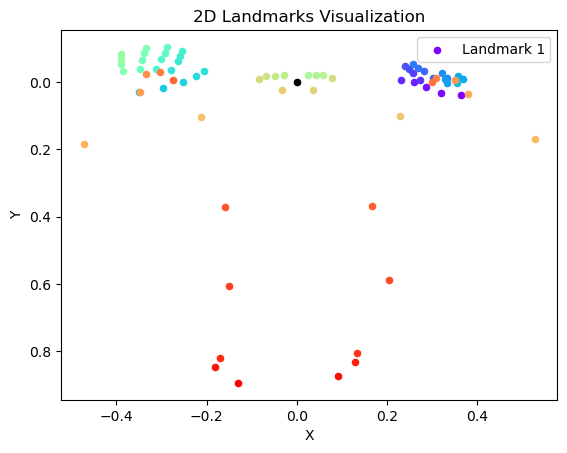

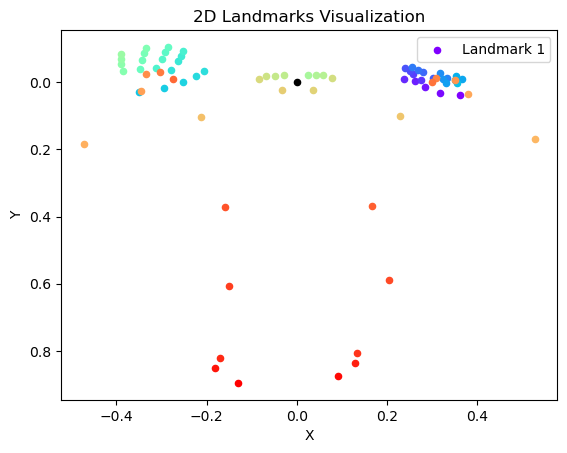

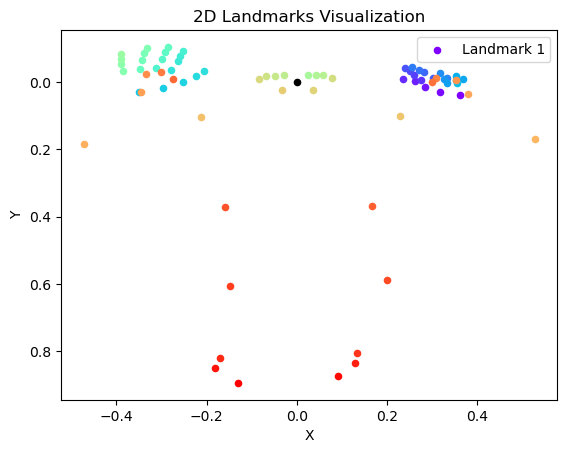

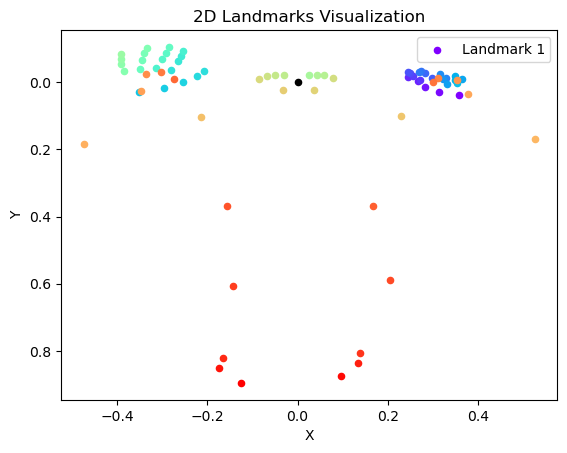

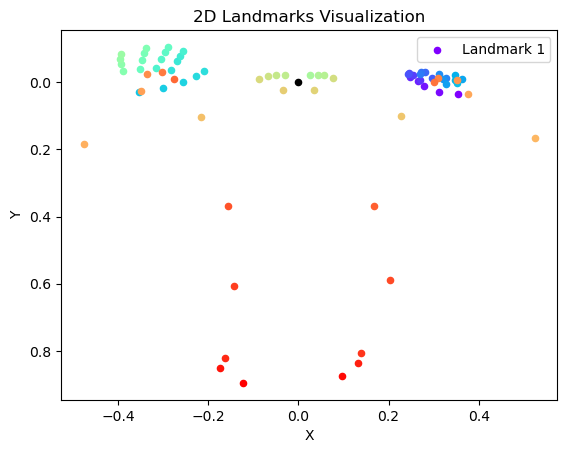

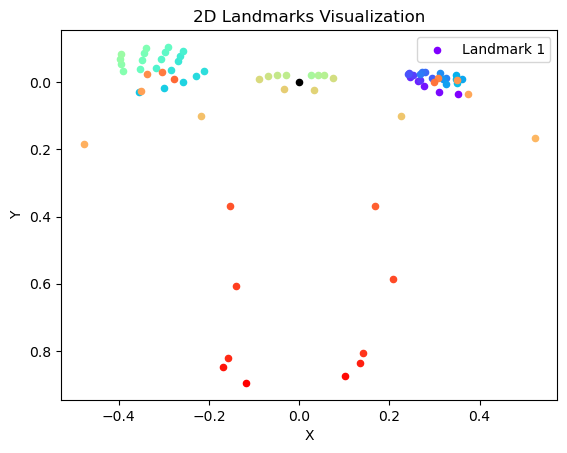

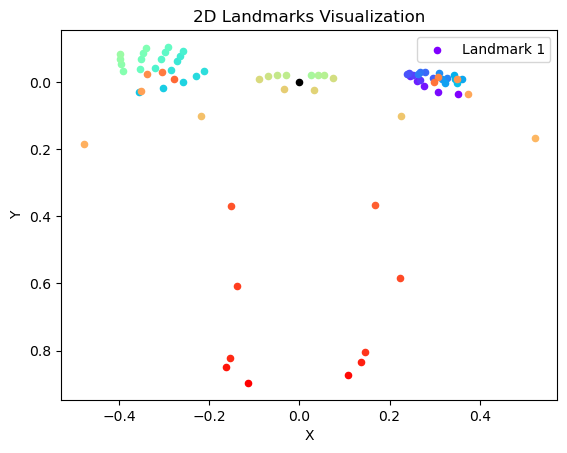

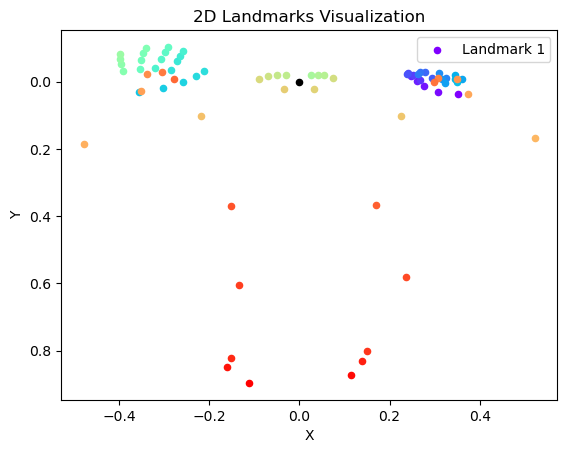

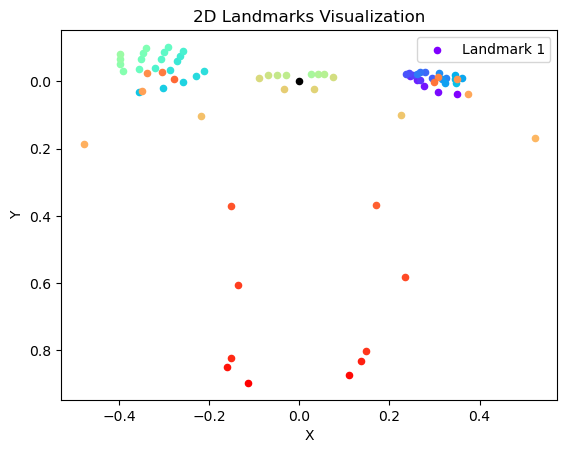

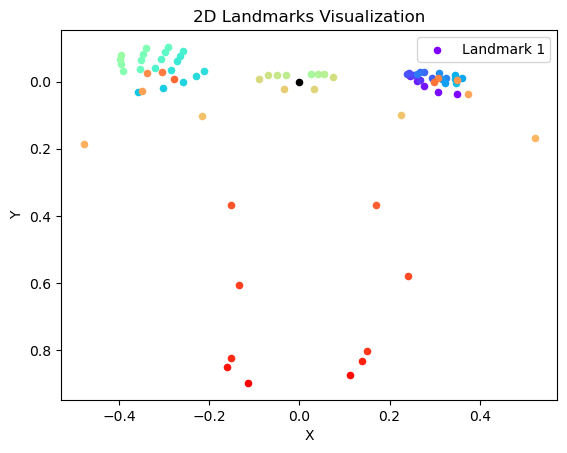

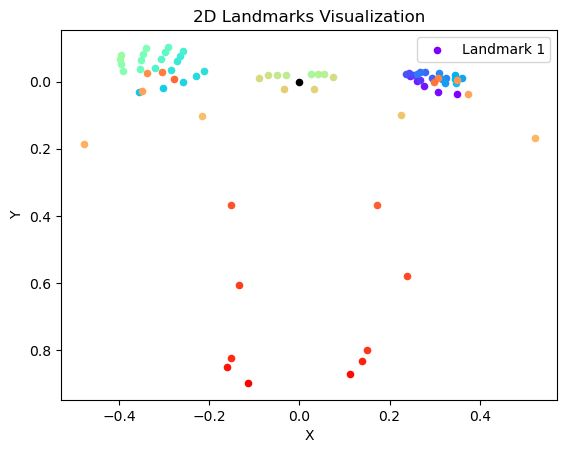

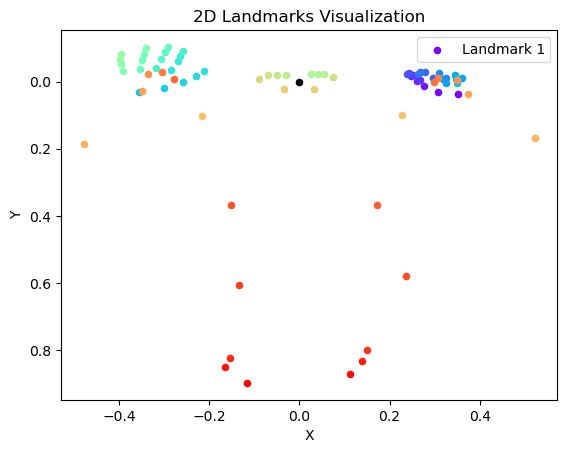

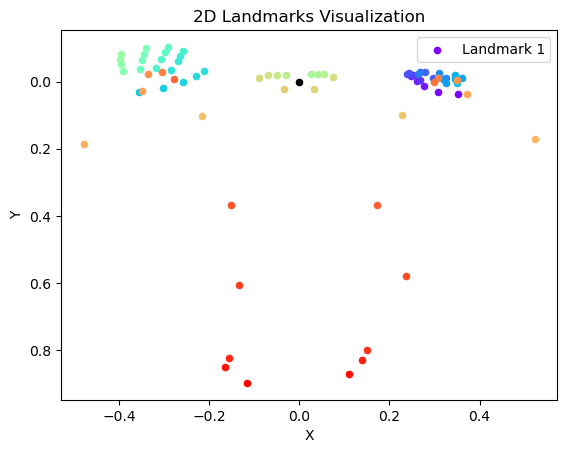

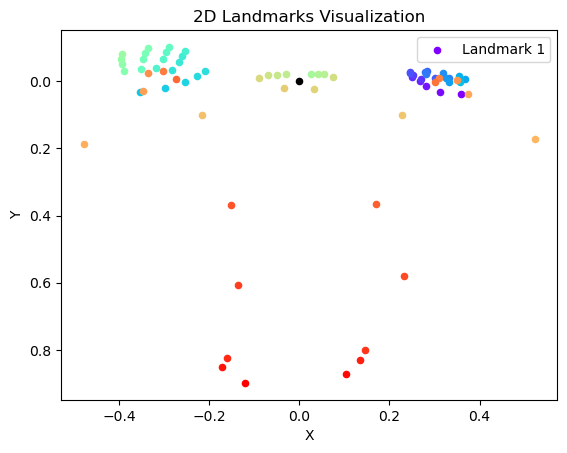

In [20]:
def plot_landmarks(frame):
    x_coords = [point[0] for point in frame]
    y_coords = [point[1] for point in frame]
    
    num_points = len(frame)
    colors = cm.rainbow(np.linspace(0, 1, num_points))

    fig = plt.figure()
    ax = fig.add_subplot(111)

    for i in range(num_points):
        if i == 42: # The reference point
            ax.scatter(x_coords[i], y_coords[i], color='black', s=20, label=f"Landmark {i+1}" if i < 1 else "")
        else:
            ax.scatter(x_coords[i], y_coords[i], color=colors[i], s=20, label=f"Landmark {i+1}" if i < 1 else "")
        

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title("2D Landmarks Visualization")
    ax.invert_yaxis()
    ax.legend()
    
    plt.show()

num_frame = 20
for i in range(num_frame):
    plot_landmarks(X[500][i])

# MODELING

In [21]:
model = CNN_RNN_Model()
criterion = nn.CrossEntropyLoss()      # Use CrossEntropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
for layer in model.state_dict():
    print(f'{layer}: {model.state_dict()[layer].shape}')

conv1.weight: torch.Size([32, 1, 3, 3])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 3, 3])
conv2.bias: torch.Size([64])
conv3.weight: torch.Size([128, 64, 3, 3])
conv3.bias: torch.Size([128])
bn1.weight: torch.Size([32])
bn1.bias: torch.Size([32])
bn1.running_mean: torch.Size([32])
bn1.running_var: torch.Size([32])
bn1.num_batches_tracked: torch.Size([])
bn2.weight: torch.Size([64])
bn2.bias: torch.Size([64])
bn2.running_mean: torch.Size([64])
bn2.running_var: torch.Size([64])
bn2.num_batches_tracked: torch.Size([])
bn3.weight: torch.Size([128])
bn3.bias: torch.Size([128])
bn3.running_mean: torch.Size([128])
bn3.running_var: torch.Size([128])
bn3.num_batches_tracked: torch.Size([])
fc1.weight: torch.Size([128, 4736])
fc1.bias: torch.Size([128])
lstm.weight_ih_l0: torch.Size([512, 128])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
lstm.weight_ih_l0_reverse: torch.Size([512, 128])
lstm.weight_hh_l0_reve

In [23]:
num_epochs = 100
for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader:  # Assuming DataLoader yields batches
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 3.7087
Epoch [2/100], Loss: 3.0405
Epoch [3/100], Loss: 2.1818
Epoch [4/100], Loss: 1.8565
Epoch [5/100], Loss: 1.7845
Epoch [6/100], Loss: 1.2419
Epoch [7/100], Loss: 1.1613
Epoch [8/100], Loss: 0.7966
Epoch [9/100], Loss: 0.8552
Epoch [10/100], Loss: 0.5369
Epoch [11/100], Loss: 0.5693
Epoch [12/100], Loss: 0.4128
Epoch [13/100], Loss: 0.4615
Epoch [14/100], Loss: 0.4755
Epoch [15/100], Loss: 0.2621
Epoch [16/100], Loss: 0.2853
Epoch [17/100], Loss: 0.2505
Epoch [18/100], Loss: 0.2591
Epoch [19/100], Loss: 0.2738
Epoch [20/100], Loss: 0.3102
Epoch [21/100], Loss: 0.1941
Epoch [22/100], Loss: 0.1499
Epoch [23/100], Loss: 0.1720
Epoch [24/100], Loss: 0.2145
Epoch [25/100], Loss: 0.0874
Epoch [26/100], Loss: 0.0996
Epoch [27/100], Loss: 0.2450
Epoch [28/100], Loss: 0.1138
Epoch [29/100], Loss: 0.0994
Epoch [30/100], Loss: 0.1085
Epoch [31/100], Loss: 0.1153
Epoch [32/100], Loss: 0.0812
Epoch [33/100], Loss: 0.0937
Epoch [34/100], Loss: 0.0629
Epoch [35/100], Loss: 0

In [24]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, dim=1)
        batch_y = torch.argmax(batch_y, dim=1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 99.67%


In [25]:
model_save_path = os.path.join(MODEL_FOLDER, 'sl1.pth')
torch.save(model.state_dict(), model_save_path)

In [26]:
for layer in model.state_dict():
    print(f'{layer}: {model.state_dict()[layer].shape}')

conv1.weight: torch.Size([32, 1, 3, 3])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 3, 3])
conv2.bias: torch.Size([64])
conv3.weight: torch.Size([128, 64, 3, 3])
conv3.bias: torch.Size([128])
bn1.weight: torch.Size([32])
bn1.bias: torch.Size([32])
bn1.running_mean: torch.Size([32])
bn1.running_var: torch.Size([32])
bn1.num_batches_tracked: torch.Size([])
bn2.weight: torch.Size([64])
bn2.bias: torch.Size([64])
bn2.running_mean: torch.Size([64])
bn2.running_var: torch.Size([64])
bn2.num_batches_tracked: torch.Size([])
bn3.weight: torch.Size([128])
bn3.bias: torch.Size([128])
bn3.running_mean: torch.Size([128])
bn3.running_var: torch.Size([128])
bn3.num_batches_tracked: torch.Size([])
fc1.weight: torch.Size([128, 4736])
fc1.bias: torch.Size([128])
lstm.weight_ih_l0: torch.Size([512, 128])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
lstm.weight_ih_l0_reverse: torch.Size([512, 128])
lstm.weight_hh_l0_reve